🚀 Starting data fetching for BTC_USDT (1d, limit=365)...
⏳ Fetching DVOL history from Deribit...
    - Fetching DVOL from Deribit API...
🔄 Aligning Price and DVOL data...
✅ Data aligned. Total data points: 365 points.
📊 Factor calculation complete. Starting backtest...


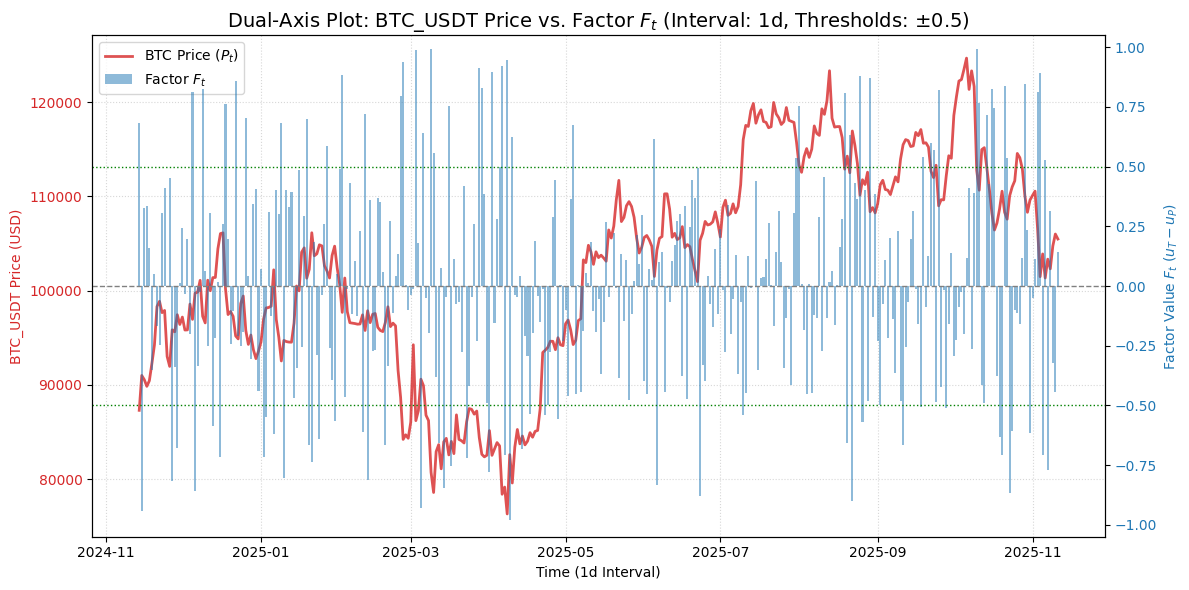

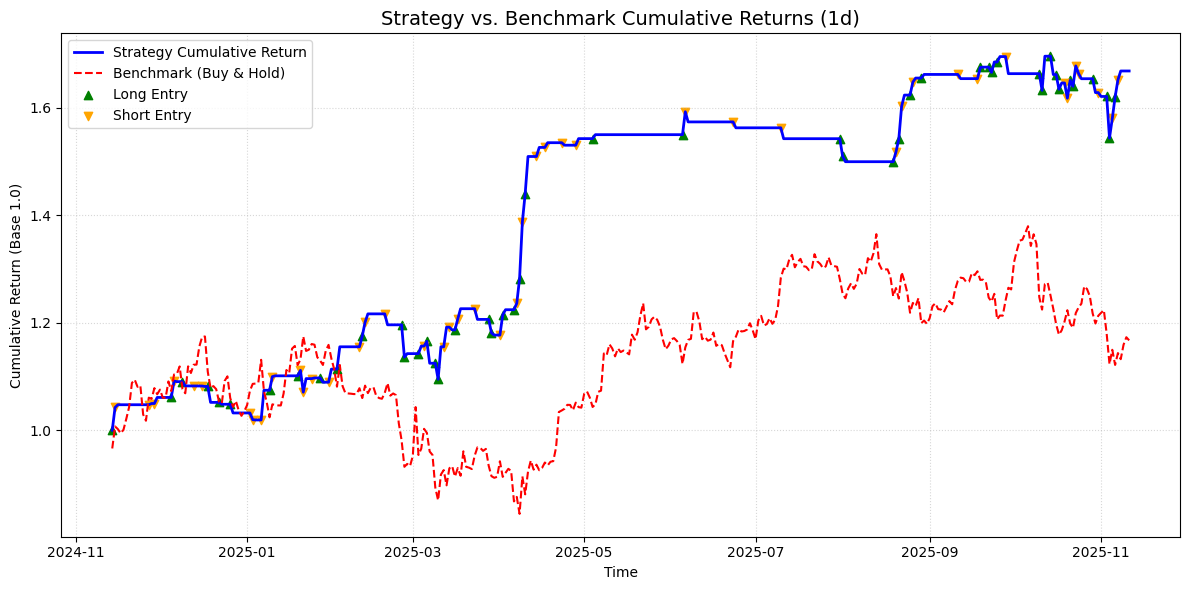


--- 回測結果摘要 ---
總共交易週期數: 363
策略最終累積報酬率: 1.67x
基準 (Buy & Hold) 最終累積報酬率: 1.17x
--------------------
📝 最後 5 筆交易訊號:
               Price  DVOL_Close         F  signal  strategy_cumulative
time                                                                   
2025-11-07  103341.2       44.61 -0.769231    -1.0             1.651528
2025-11-08  102316.2       44.88  0.315934     0.0             1.668073
2025-11-09  104731.1       45.11 -0.321429     0.0             1.668073
2025-11-10  106002.9       44.30 -0.445055     0.0             1.668073
2025-11-11  105478.0       44.29  0.142857     0.0             1.668073


In [29]:
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from datetime import datetime, timedelta

# --- Configurations ---
GATEIO_HOST = "https://api.gateio.ws"
DERIBIT_HOST = "https://www.deribit.com/api/v2/public" # Deribit Public API
GATEIO_PREFIX = "/api/v4"
# ----------------------

# -----------------------------
# 1. Fetch Spot K-Line History Close Prices (Gate.io)
# -----------------------------
def fetch_price_history(symbol, interval, limit): 
    """
    從 Gate.io 抓取 K 線歷史收盤價，並返回帶有時間戳的 DataFrame。
    """
    url = f"{GATEIO_HOST}{GATEIO_PREFIX}/spot/candlesticks"
    params = {
        "currency_pair": symbol,
        "interval": interval, 
        "limit": limit
    }
    resp = requests.get(url, params=params)
    resp.raise_for_status()
    data = resp.json()
    
    # 修正: Gate.io API v4 K線數據格式已變更，現在返回 8 個欄位。
    df = pd.DataFrame(data, columns=['time', 'volume', 'close', 'high', 'open', 'low', 'quote_volume', 'count'])
    
    df['time'] = pd.to_datetime(df['time'].astype(int), unit='s')
    df['close'] = df['close'].astype(float)
    df = df.sort_values('time').reset_index(drop=True)
    
    return df[['time', 'close']].rename(columns={'close': 'Price'})

# -----------------------------
# 2. Fetch DVOL Historical Data (Deribit)
# -----------------------------
def fetch_dvol_history(start_time_ms, end_time_ms, index_name="BTC_DVOL", resolution=86400, currency="BTC"): 
    """
    從 Deribit 抓取 DVOL 歷史數據。
    resolution=86400 表示 86400 秒，即 1 天。
    """
    url = f"{DERIBIT_HOST}/get_volatility_index_data"
    params = {
        "index_name": index_name,
        "start_timestamp": start_time_ms,
        "end_timestamp": end_time_ms,
        "resolution": resolution, # 86400 seconds = 1 Day (修正)
        "currency": currency 
    }
    
    print(f"    - Fetching DVOL from Deribit API...")
    resp = requests.get(url, params=params)
    resp.raise_for_status() 
    data = resp.json()
    
    if data['result'] is None or 'data' not in data['result']:
        raise ValueError("DVOL data not found or API response error.")
        
    dvol_data = data['result']['data']
    
    df = pd.DataFrame(dvol_data, columns=['time_ms', 'open', 'high', 'low', 'DVOL_Close'])
    df['time'] = pd.to_datetime(df['time_ms'], unit='ms')
    df['DVOL_Close'] = df['DVOL_Close'].astype(float)
    
    return df[['time', 'DVOL_Close']].sort_values('time')

# -----------------------------
# Main Program
# -----------------------------
def main():
    
    # ===============================================
    ## 🛠️ 參數設置區域 (可調整區域)
    # ===============================================
    SYMBOL = "BTC_USDT"
    # ===============================================
    ## 🛠️ 參數設置區域 (建議調整後的參數)
    # ===============================================
    PRICE_INTERVAL = "1d" 
    DVOL_RESOLUTION = 86400 # 1 Day
    LIMIT = 365 # 增加到 2000，獲取更穩定排名

    # 訊號閾值 F_t (降低門檻，捕捉更多訊號)
    LONG_THRESHOLD = 0.5  # 降低到 0.60
    SHORT_THRESHOLD = -0.5 # 降低到 -0.60
    # ===============================================

    print(f"🚀 Starting data fetching for {SYMBOL} ({PRICE_INTERVAL}, limit={LIMIT})...")
    
    # 1. Fetch Price History (Gate.io)
    try:
        df_price = fetch_price_history(SYMBOL, interval=PRICE_INTERVAL, limit=LIMIT)
    except Exception as e:
        print(f"🔴 Failed to fetch price history from Gate.io: {e}")
        return

    # 設置 DVOL 抓取時間範圍
    end_time = df_price['time'].max()
    start_time = df_price['time'].min()
    
    end_time_ms = int(end_time.timestamp() * 1000)
    start_time_ms = int((start_time - timedelta(days=2)).timestamp() * 1000) # 往前推兩天

    # 2. Fetch DVOL Time Series (Deribit)
    print("⏳ Fetching DVOL history from Deribit...")
    try:
        df_dvol = fetch_dvol_history(
            start_time_ms, 
            end_time_ms, 
            index_name="BTC_DVOL", 
            resolution=DVOL_RESOLUTION, # 使用設置的 Resolution
            currency="BTC"
        )
    except Exception as e:
        print(f"🔴 Failed to fetch DVOL history: {e}")
        return
        
    # --- 3. Data Alignment ---
    print("🔄 Aligning Price and DVOL data...")
    
    df_aligned = pd.merge_asof(
        left=df_price, 
        right=df_dvol, 
        on='time', 
        direction='nearest'
    )
    
    df_aligned = df_aligned.dropna(subset=['DVOL_Close']).set_index('time')
    
    if len(df_aligned) < 2:
        print("🔴 數據點不足，無法計算報酬率和變化量。")
        return
        
    print(f"✅ Data aligned. Total data points: {len(df_aligned)} points.")

    # --- 4. Calculate Factor and Signals ---
    
    df_aligned['rtP'] = np.log(df_aligned['Price']).diff()
    df_aligned['rtT'] = df_aligned['DVOL_Close'].diff()
    
    df_factor = df_aligned.dropna(subset=['rtP', 'rtT']).copy()

    # Calculate Non-Parametric Factor F
    df_factor['uP'] = df_factor['rtP'].rank(pct=True)
    df_factor['uT'] = df_factor['rtT'].rank(pct=True)
    df_factor['F'] = df_factor['uT'] - df_factor['uP']

    # Generate Trading Signals
    # 因子 F > LONG_THRESHOLD -> Long (預期價格上漲)
    # 因子 F < SHORT_THRESHOLD -> Short (預期價格下跌)
    df_factor['signal'] = 0.0 # 0.0 代表中性
    df_factor.loc[df_factor['F'] > LONG_THRESHOLD, 'signal'] = 1.0 # Long
    df_factor.loc[df_factor['F'] < SHORT_THRESHOLD, 'signal'] = -1.0 # Short
    
    print("📊 Factor calculation complete. Starting backtest...")

    # --- 5. Backtest Simulation (報酬率計算) ---
    
    # 計算策略報酬率 (策略只在發出訊號的下一個週期入場，並持倉到下一個訊號)
    # 策略報酬率 = 訊號 * 實際對數報酬率
    df_factor['strategy_return'] = df_factor['signal'].shift(1) * df_factor['rtP']
    
    # 移除第一個 shift(1) 產生的 NaN
    df_factor = df_factor.dropna(subset=['strategy_return'])
    
    # 計算基準報酬率 (Buy & Hold)
    df_factor['benchmark_return'] = df_factor['rtP']
    
    # 計算累積報酬率
    df_factor['strategy_cumulative'] = np.exp(df_factor['strategy_return'].cumsum())
    df_factor['benchmark_cumulative'] = np.exp(df_factor['benchmark_return'].cumsum())

    # --- 6. Plotting (因子圖 + 報酬率曲線圖) ---
    
    # 圖 1: 因子與價格
    fig1, ax1 = plt.subplots(figsize=(12, 6))
    color = 'tab:red'
    ax1.set_xlabel(f'Time ({PRICE_INTERVAL} Interval)')
    ax1.set_ylabel(f'{SYMBOL} Price (USD)', color=color)
    ax1.plot(df_factor.index, df_factor['Price'], color=color, linewidth=2, label='BTC Price ($P_t$)', alpha=0.8)
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.grid(True, which='both', linestyle=':', alpha=0.5)

    ax2 = ax1.twinx()
    color = 'tab:blue'
    ax2.set_ylabel('Factor Value $F_t$ ($u_T - u_P$)', color=color)  
    
    time_diffs = df_factor.index.to_series().diff().dropna()
    bar_width = time_diffs.min() * 0.8 if len(time_diffs) > 0 else timedelta(hours=20)
    
    ax2.bar(df_factor.index, df_factor['F'], color=color, alpha=0.5, label='Factor $F_t$', width=bar_width)
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.axhline(0, color='gray', linestyle='--', linewidth=1)
    ax2.axhline(LONG_THRESHOLD, color='green', linestyle=':', linewidth=1)
    ax2.axhline(SHORT_THRESHOLD, color='green', linestyle=':', linewidth=1)
    ax2.set_ylim(-1.05, 1.05) 

    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')
    plt.title(f"Dual-Axis Plot: {SYMBOL} Price vs. Factor $F_t$ (Interval: {PRICE_INTERVAL}, Thresholds: $\pm{LONG_THRESHOLD}$)", fontsize=14)
    fig1.tight_layout()
    plt.show()


    # 圖 2: 策略累積報酬率曲線
    fig2, ax3 = plt.subplots(figsize=(12, 6))
    ax3.plot(df_factor.index, df_factor['strategy_cumulative'], label='Strategy Cumulative Return', color='blue', linewidth=2)
    ax3.plot(df_factor.index, df_factor['benchmark_cumulative'], label='Benchmark (Buy & Hold)', color='red', linestyle='--')
    
    # 繪製訊號點
    long_entries = df_factor[df_factor['signal'] == 1.0]
    short_entries = df_factor[df_factor['signal'] == -1.0]
    
    ax3.scatter(long_entries.index, long_entries['strategy_cumulative'], marker='^', color='green', label='Long Entry')
    ax3.scatter(short_entries.index, short_entries['strategy_cumulative'], marker='v', color='orange', label='Short Entry')


    ax3.set_title(f'Strategy vs. Benchmark Cumulative Returns ({PRICE_INTERVAL})', fontsize=14)
    ax3.set_xlabel('Time')
    ax3.set_ylabel('Cumulative Return (Base 1.0)')
    ax3.grid(True, which='both', linestyle=':', alpha=0.5)
    ax3.legend(loc='upper left')
    fig2.tight_layout()
    plt.show()

    # --- 7. Output Final Metrics ---
    
    final_strategy_return = df_factor['strategy_cumulative'].iloc[-1]
    final_benchmark_return = df_factor['benchmark_cumulative'].iloc[-1]
    
    print("\n--- 回測結果摘要 ---")
    print(f"總共交易週期數: {len(df_factor)}")
    print(f"策略最終累積報酬率: {final_strategy_return:.2f}x")
    print(f"基準 (Buy & Hold) 最終累積報酬率: {final_benchmark_return:.2f}x")
    print("-" * 20)
    print("📝 最後 5 筆交易訊號:")
    print(df_factor[['Price', 'DVOL_Close', 'F', 'signal', 'strategy_cumulative']].tail(5))
    
if __name__ == "__main__":
    main()